In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# defining the propagator matrices

# Parameters and size of the matrix
def returnEulerPropagator1(n,lam):
    # Correctly implementing the Euler propagation matrix (Â)
    A_hat_final = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                A_hat_final[i, j] = 1 - 2 * lam  # Diagonal elements
            elif abs(i - j) == 1:
                A_hat_final[i, j] = lam  # Off-diagonal elements
                if (i == 0 and j == 1) or (i == n - 1):
                    A_hat_final[i, j] = 2 * lam  # Boundary-specific elements
    return A_hat_final

# sign- tells whether the forward or backward CN is to be returned:
def returnCNPropagator1(n, lam, sign=1):
    # Create Crank-Nicolson matrices (A^+ and A^-)
    A_plus = np.zeros((n, n))
    A_minus = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                A_plus[i, j] = (1 - lam)
                A_minus[i, j] = (1 + lam)
            elif abs(i - j) == 1:
                A_plus[i, j] = lam / 2
                A_minus[i, j] = -lam / 2
                if i==0 or i==n-1:
                    A_plus[i, j] = lam
                    A_minus[i, j] = -lam
    
    if sign == 1:
        return A_plus
    elif sign == -1:
        return A_minus
    
    
# returning the B_matrix, containing the constant term as a result of the VON NEUMANN BCs
def returnBmatrix(lam, dx, Cprime_start, Cprime_end, N, method = "euler"):
    B = np.zeros(N)
    
    if method == "euler":
        B[0] =  -2 * lam * dx * Cprime_start
        B[-1] = 2 * lam * dx * Cprime_end
    elif method== "cn":
        B[0] =  -1 * lam * dx * Cprime_start
        B[-1] = 1 * lam * dx * Cprime_end
        
    return B
    

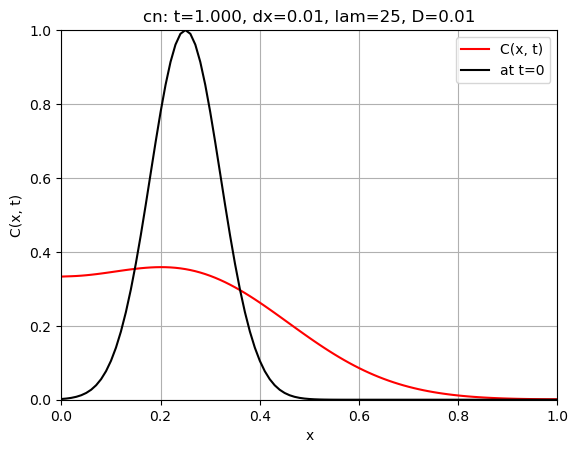

In [2]:
# RUNNING THE EULER CASE USING ANIMATION

method = "cn"

"""  initial profile to be taken as Gaussian,
defining the spatial grid and """

# creating the x-grid with the step size 0.01 (as given in the lecture notes)
dx = 0.01
x_start = 0
x_end = 1 
x = np.arange(x_start,x_end + dx,dx)

N = len(x) # no of data points in the x-grid determines the size of the array in 

x_peak = 0.25 # defining the initial Gaussian Profile, centred around this value
sigma = 0.1 # spread of the Gauss
C0 = []
for x_el in x:
    C0.append(np.exp(- (x_el-x_peak)**2 / sigma **2 ))
    


""" setting up the problem """

# defining the parameters
# dx = defined above already, 0.01
D = 0.01
lam = 25

dt = lam * dx**2 / D

# obtaining the matrices for C[t_n+dt] = A C[t_n] + B
if method=="euler":
    A = returnEulerPropagator1(N, lam)
    B = returnBmatrix(lam, dx, 0, 0, N, method="euler")
elif method=="cn":
    Aplus = returnCNPropagator1(N, lam , sign=1)
    Aminus = returnCNPropagator1(N, lam, sign=-1)
    B = returnBmatrix(lam, dx, 0, 0, N, method="cn")

# now we can implement the matrix calculation
t = np.arange(0, 1+dt, dt)


Cn = C0 

""" setting up the animation """
# Prepare figure for animation
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r', label="C(x, t)")
initial_line, = ax.plot(x, C0, 'k', label="at t=0")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("C(x, t)")
ax.legend()
ax.grid()
ax.set_title(f"Crank-Nicolson: dx={dx}, lam={lam}, D={D}")

# Update function for animation
def update(frame):
    global Cn
    t_el = t[frame]
    
    # Compute next time step
    if method == "euler":
        Cn_plus_1 = np.dot(A,Cn) + B
        
        Cn = Cn_plus_1
    elif method== "cn":
        C_intermediate = np.dot(Aplus, Cn) + B
        Cn_plus_1 = np.linalg.solve(Aminus, C_intermediate + B)
        
        Cn = Cn_plus_1
    
    # Update line data
    line.set_data(x, Cn)
    ax.set_title(f"{method}: t={t_el:.3f}, dx={dx}, lam={lam}, D={D}")
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)

# To display animation in Jupyter Notebook
HTML(ani.to_jshtml())